Imports Required for the modelling

In [1]:
import pandas as pd #dataframe
import numpy as np #numpy
#Sklearn models
from mlxtend.feature_selection import SequentialFeatureSelector as sfs #estimator
from sklearn.model_selection import train_test_split #split x_train, x_test
from sklearn.ensemble import RandomForestClassifier #Classifier random
from sklearn import tree #Classifier decision tree
from sklearn.metrics import accuracy_score as acc #scoring
from sklearn.linear_model import LogisticRegression #classifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer #imputer
from sklearn.preprocessing import StandardScaler #scaler
import matplotlib.pyplot as plt  #plot graphs
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix #confusion matrix
from sklearn.model_selection import train_test_split # test train splitter
from sklearn.feature_selection import mutual_info_classif #mutual info

#deep learning models
import tensorflow as tf #tensorflow
from tensorflow import keras #keras
from keras import Sequential 
from keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense



In [2]:
np.random.seed(seed=42)

Load prepared data to Dataframe

In [3]:
my_df=pd.read_csv('data.csv') #data


Preparing Data for Binary Classification

In [4]:
y=my_df['Target'].copy() # set y as target value (positive and negative) - binary
x=my_df.drop(['Age','Plasma_volume(mL)','Tumor_type','AJCC_Stage','Sex',
       'Plasma_DNA_concentration(ng/mL)', 'Mutation_identified_in_plasma',
       'Mutant_allele_frequency(%)', 'Mutant_fragments/mL_plasma','Mutation_identified_in_plasma','Target','Patient_ID','Sample_ID','Tumor_type','AJCC_Stage','Histopathology','Race','Unnamed: 0'],axis=1)
# Set x with protien biomarkers

Few columns have null values, imputing the values with median and scaling the dataset

In [5]:
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
('std_scaler', StandardScaler()),
]) #created pipeline with Imputer and scalar

df_prepared = num_pipeline.fit_transform(x) #passing prepared x to the pipeline
new_x = pd.DataFrame(df_prepared) #converting transformed data to DF
new_x.columns = x.columns

Test Train Split, 75% train data, 25% test data

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    new_x, # imputed and scaled values of x 
    y, # y labels
    test_size=0.25, # test size to 25%
    random_state=42) #random state 42 to maintain even distribution every time the data is sliced

#### creating a list of column names identified using domain knowledge

In [7]:
report_clms=['CA19-9(U/ml)','HGF(pg/ml)','CA-125(U/ml)','OPN(pg/ml)','CEA(pg/ml)',
             'Ω score','Prolactin(pg/ml)','Myeloperoxidase(ng/ml)','TIMP-1(pg/ml)']


Mutual Info Classification: 
Gives weigthage of each column 

In [8]:
mutual_info = mutual_info_classif(x_train[report_clms], y_train) #using train data to calculate 
mutual_info = pd.Series(mutual_info)
mutual_info.index = x_train[report_clms].columns
pd.DataFrame(mutual_info.sort_values(ascending=False))

,0
CA19-9(U/ml),0.496480
CA-125(U/ml),0.402727
HGF(pg/ml),0.394341
CEA(pg/ml),0.201944
OPN(pg/ml),0.201156
Ω score,0.139120
Prolactin(pg/ml),0.130786
Myeloperoxidase(ng/ml),0.111053
TIMP-1(pg/ml),0.095726


## Random Forest

#### Training the estimator using the columns identified from domain knowledge

In [9]:
clf_random = RandomForestClassifier()  #random forest - n_estimators set to default to minimize time taken for prediction

clf_random.fit(x_train[report_clms], y_train)

y_test_pred_domain = clf_random.predict(x_test[report_clms])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred_domain))

Testing accuracy on selected features: 0.916


#### Random Forest Classification model with Sequential Feature Selector

In [17]:
### The code for SFS - Forward

sfs_random = sfs(RandomForestClassifier(n_estimators=100, n_jobs=-1), #estimator set to default
           k_features=(1,x_train.shape[1]),
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

sfs_random = sfs_random.fit(x_train, y_train) #fitting the model with train data

In [16]:
feat_cols = list(sfs_random.k_feature_idx_) #list of selected best features for binary
print(x_train[x_train.columns[feat_cols]].head(0)) #print names of selected columns


In [18]:
import pickle

# pickle.dump(sfs_random, open(filename, 'wb'))

In [19]:
filename = 'sfs_random.sav'
loaded_model = pickle.load(open(filename, 'rb'))

#### Columns identified using SFS

In [20]:
feat_cols = list(loaded_model.k_feature_idx_) #list of selected best features for binary
print(x_train[x_train.columns[feat_cols]].head(0)) #print names of selected columns

Empty DataFrame
Columns: [AFP(pg/ml), DKK1(ng/ml), G-CSF(pg/ml), GDF15(ng/ml), HE4(pg/ml), Mesothelin(ng/ml), OPG(ng/ml), sFas(pg/ml), TGFa(pg/ml)]
Index: []


In [21]:
x_train[x_train.columns[feat_cols]]

,AFP(pg/ml),DKK1(ng/ml),G-CSF(pg/ml),GDF15(ng/ml),HE4(pg/ml),Mesothelin(ng/ml),OPG(ng/ml),sFas(pg/ml),TGFa(pg/ml)
722,-0.121333,0.088608,-0.169896,0.299078,0.735978,-0.130283,-0.070880,-0.505827,-0.041290
1204,-0.120492,-1.041861,-0.380885,-0.544404,-0.184776,0.247516,-0.087385,-0.099156,-0.042053
1316,-0.120729,-0.318360,-0.206356,-0.583185,-0.207537,-0.438633,-0.334963,-0.236313,-0.043112
405,-0.116736,-0.476626,-0.182534,-0.282633,-0.162865,-0.232603,-0.301952,-0.507907,-0.038917
1406,-0.108758,0.834718,-0.181517,-0.205072,-0.180056,-0.376593,0.011645,0.287241,-0.006811
...,...,...,...,...,...,...,...,...,...
1130,-0.115130,-1.109689,-0.206356,-0.563794,-0.207537,-0.241863,-0.417488,0.508680,-0.043112
1294,-0.119571,0.879937,-0.191394,-0.563794,-0.179926,-0.325664,-0.400983,-0.216971,-0.040909
860,0.004527,-0.001829,-0.169896,1.045609,0.735978,1.577219,0.506799,-0.505827,-0.041290
1459,-0.118900,2.914781,-0.181517,1.229817,-0.180056,-0.243252,0.523305,0.258140,-0.039934


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa3d3f45f90>,
      dtype=object)

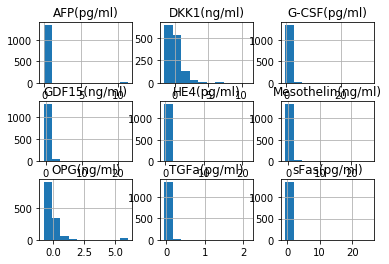

In [22]:
x_train[x_train.columns[feat_cols]].hist()

Random Forest classifier fitted with features extracted from SFS

In [23]:
clf_random = RandomForestClassifier(min_samples_split=8,bootstrap=True,max_depth=80,max_features=3,min_samples_leaf=3,n_estimators=200, n_jobs=-1)  #random forest - n_estimators set to default to minimize time taken for prediction

clf_random.fit(x_train[x_train.columns[feat_cols]], y_train)

y_test_pred_sfs = clf_random.predict(x_test[x_test.columns[feat_cols]])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred_sfs))

Testing accuracy on selected features: 0.960


#### Plotting Confusion matrix for the random forest classifier with features that were selected using SFS

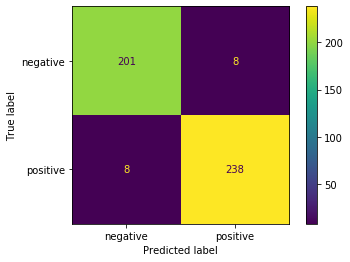

In [24]:
clf_random = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_random.fit(x_train[x_train.columns[feat_cols]], y_train)

plot_confusion_matrix(clf_random, x_test[x_test.columns[feat_cols]], y_test)  
plt.show() 

#### Plotting Confusion matrix for the random forest classifier with features that were identified using domain knowledge

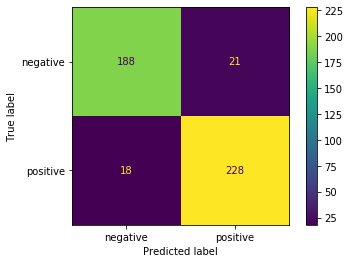

In [25]:
clf_random = RandomForestClassifier(n_estimators=100, n_jobs=-1)
clf_random.fit(x_train[report_clms], y_train)

plot_confusion_matrix(clf_random, x_test[report_clms], y_test)  
plt.show() 

#### Calulating the Specificity and sensitivity of predicted labels to evaluate performance of the model

In [26]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 'positive'
    actual_neg = y_test == 'negative'
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 'positive') & (actual_pos)
    false_pos = (y_pred_test == 'positive') & (actual_neg)
    true_neg = (y_pred_test == 'negative') & (actual_neg)
    false_neg = (y_pred_test == 'negative') & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    
    return sensitivity, specificity, accuracy



#### features that were identified using domain knowledge

In [27]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y_test, y_test_pred_domain)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.9186991869918699
Specificity: 0.9138755980861244
Accuracy: 0.9164835164835164


#### features that were selected using SFS

In [28]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y_test, y_test_pred_sfs)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.9715447154471545
Specificity: 0.9473684210526315
Accuracy: 0.9604395604395605


## Decision Tree

#### Decision Tree Classifier model with  with Sequential Feature Selector 

In [29]:
clf_tree = tree.DecisionTreeClassifier()
sfs_tree = sfs(clf_tree,
           k_features=(1,x_train.shape[1]),
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs_tree = sfs_tree.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.0s finished

[2021-03-11 23:35:00] Features: 1/40 -- score: 0.9375834949364361[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    0.7s finished

[2021-03-11 23:35:01] Features: 2/40 -- score: 0.9383403361344538[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    0.7s finished

[2021-03-11 23:35:01] Features: 3/40 -- score: 0.9427386339151045[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.1s finished

[2021-03-11 23:35:31] Features: 28/40 -- score: 0.9214555052790345[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.1s finished

[2021-03-11 23:35:33] Features: 29/40 -- score: 0.9265944839474252[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    1.0s finished

[2021-03-11 23:35:34] Features: 30/40 -- score: 0.9258699633699635[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.0s finished

[2021-03-11 23:35:35] Features: 31/

In [30]:
feat_cols_tree = list(sfs_tree.k_feature_idx_) #list of selected best features for binary
print(x_train[x_train.columns[feat_cols_tree]].head(0)) #print names of selected columns

Empty DataFrame
Columns: [HE4(pg/ml), HGF(pg/ml), TGFa(pg/ml)]
Index: []


In [31]:
clf_dec = tree.DecisionTreeClassifier()

clf_dec.fit(x_train[x_train.columns[feat_cols_tree]], y_train)

y_test_pred_dec = clf_dec.predict(x_test[x_test.columns[feat_cols_tree]])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred_dec))

Testing accuracy on selected features: 0.936


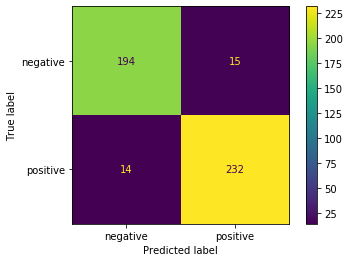

In [32]:
plot_confusion_matrix(clf_dec, x_test[x_test.columns[feat_cols_tree]], y_test)  
plt.show() 

In [33]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y_test, y_test_pred_dec)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.943089430894309
Specificity: 0.9282296650717703
Accuracy: 0.9362637362637363


## Logistic Regression

In [34]:
sfs_linear = sfs(LogisticRegression(solver='lbfgs',random_state=42),
           k_features=(1,x_train.shape[1]),
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy',
           cv=5)

# Perform SFFS
sfs_linear = sfs_linear.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.9s finished

[2021-03-11 23:35:41] Features: 1/40 -- score: 0.7599008834302952[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    1.1s finished

[2021-03-11 23:35:42] Features: 2/40 -- score: 0.8002908855850034[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    1.1s finished

[2021-03-11 23:35:43] Features: 3/40 -- score: 0.8149752208575738[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    1.4s finished

[2021-03-11 23:36:19] Features: 28/40 -- score: 0.8671110751993105[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.3s finished

[2021-03-11 23:36:20] Features: 29/40 -- score: 0.8671003016591252[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.9s finished

[2021-03-11 23:36:21] Features: 30/40 -- score: 0.8693034906270201[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.9s finished

[2021-03-11 23:36:22] Features: 31/

In [35]:
sfs_linear_cols = list(sfs_linear.k_feature_idx_)
x_train[x_train.columns[sfs_linear_cols]].head(0)

,Ω score,AFP(pg/ml),Angiopoietin-2(pg/ml),AXL(pg/ml),CA-125(U/ml),CA-15-3(U/ml),CA19-9(U/ml),CD44(ng/ml),CEA(pg/ml),CYFRA-21-1(pg/ml),...,Prolactin(pg/ml),sEGFR(pg/ml),sFas(pg/ml),SHBG(nM),sHER2/sEGFR2/sErbB2(pg/ml),sPECAM-1(pg/ml),TGFa(pg/ml),Thrombospondin-2(pg/ml),TIMP-1(pg/ml),TIMP-2(pg/ml)


In [36]:
clf_random = LogisticRegression(solver='lbfgs',random_state=42)

clf_random.fit(x_train[x_train.columns[sfs_linear_cols]], y_train)

# y_train_pred = clf.predict(x_train[x_train.columns[feat_cols]])
# print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf_random.predict(x_test[x_test.columns[sfs_linear_cols]])
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Testing accuracy on selected features: 0.862


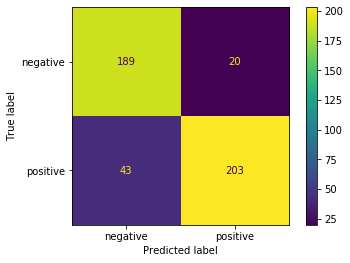

In [37]:
clf_random.fit(x_train[x_train.columns[sfs_linear_cols]], y_train)

plot_confusion_matrix(clf_random, x_test[x_test.columns[sfs_linear_cols]], y_test)  
plt.show() 

In [38]:
sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y_test, y_test_pred)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.8252032520325203
Specificity: 0.9043062200956937
Accuracy: 0.8615384615384616


## Deep Learning

In [39]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
encoded_Y


array([1, 1, 1, ..., 1, 1, 1])

In [40]:

from sklearn.model_selection import train_test_split
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(new_x, encoded_Y, test_size=0.3)



#### We now split the input features and target variables into training dataset and test dataset. our test dataset will be 30% of our entire dataset.


#### Neural network
We are using keras to build our neural network. We import the keras library to create the neural network layers.
There are two main types of models available in keras — Sequential and Model. we will use Sequential model to build our neural network.
We use Dense library to build input, hidden and output layers of a neural network.

What is Keras?
1. Keras is a high-level neural network API which is written in Python.
2. It is capable of running on top of Tensorflow, CNTK, or Theano.
3. Keras can be used as a deep learning library. Support Convolutional and Recurrent Neural Networks
4. Prototyping with Keras is fast and easy
5. Runs seamlessly on CPU and GPU

relu: Rectified Linear Activation

In [41]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal', input_dim=40))
#Second  Hidden Layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
# Third hidden layer
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#### ReLu will be the activation function for hidden layers. As this is a binary classification problem we will use sigmoid as the activation function.


In [42]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

1. As this is a binary classification problem, we use binary_crossentropy to calculate the loss function between the actual output and the predicted output.
2. To optimize our neural network we use Adam. Adam stands for Adaptive moment estimation.
3. Momentum takes the past gradients into account in order to smooth out the gradient descent.
4. we use accuracy as the metrics to measure the performance of the model

we now fit out training data to the model we created. we use a batch_size of 10. This implies that we use 10 samples per gradient update.
We iterate over 100 epochs to train the model. An epoch is an iteration over the entire data set.

#### With all Protein biomarkers 


In [43]:

#Fitting the data to the training dataset
classifier.fit(X_train_d,y_train_d, batch_size=10, epochs=100)

y_pred_d=classifier.predict(X_test_d)
y_pred_d =(y_pred_d>0.5)


y_pred_d=[0 if  i == False else 1 for i in y_pred_d]

y_pred_arr = np.array(y_pred_d)

Epoch 1/100
128/128 [==============================] - 0s 622us/step - loss: 0.6909 - accuracy: 0.5531
Epoch 2/100
128/128 [==============================] - 0s 572us/step - loss: 0.6333 - accuracy: 0.5547
Epoch 3/100
128/128 [==============================] - 0s 573us/step - loss: 0.5208 - accuracy: 0.6042
Epoch 4/100
128/128 [==============================] - 0s 563us/step - loss: 0.4729 - accuracy: 0.8434
Epoch 5/100
128/128 [==============================] - 0s 573us/step - loss: 0.4458 - accuracy: 0.8631
Epoch 6/100
128/128 [==============================] - 0s 572us/step - loss: 0.4250 - accuracy: 0.8647
Epoch 7/100
128/128 [==============================] - 0s 593us/step - loss: 0.4067 - accuracy: 0.8725
Epoch 8/100
128/128 [==============================] - 0s 602us/step - loss: 0.3899 - accuracy: 0.8733
Epoch 9/100
128/128 [==============================] - 0s 560us/step - loss: 0.3747 - accuracy: 0.8757
Epoch 10/100
128/128 [==============================] - 0s 545us/step - l

128/128 [==============================] - 0s 543us/step - loss: 0.1504 - accuracy: 0.9489
Epoch 80/100
128/128 [==============================] - 0s 536us/step - loss: 0.1513 - accuracy: 0.9473
Epoch 81/100
128/128 [==============================] - 0s 549us/step - loss: 0.1512 - accuracy: 0.9473
Epoch 82/100
128/128 [==============================] - 0s 544us/step - loss: 0.1492 - accuracy: 0.9528
Epoch 83/100
128/128 [==============================] - 0s 542us/step - loss: 0.1475 - accuracy: 0.9528
Epoch 84/100
128/128 [==============================] - 0s 539us/step - loss: 0.1498 - accuracy: 0.9489
Epoch 85/100
128/128 [==============================] - 0s 540us/step - loss: 0.1475 - accuracy: 0.9504
Epoch 86/100
128/128 [==============================] - 0s 544us/step - loss: 0.1473 - accuracy: 0.9512
Epoch 87/100
128/128 [==============================] - 0s 535us/step - loss: 0.1466 - accuracy: 0.9489
Epoch 88/100
128/128 [==============================] - 0s 561us/step - loss:

In [44]:
def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary.
    # This would allow return of other measures other than sensitivity and specificity
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test)
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos)
    specificity = np.sum(true_neg) / np.sum(actual_neg)
    return sensitivity, specificity, accuracy


sensitivity, specificity, accuracy = calculate_sensitivity_specificity(y_test_d, y_pred_arr)
print ('Sensitivity:', sensitivity)
print ('Specificity:', specificity)
print ('Accuracy:', accuracy)

Sensitivity: 0.8666666666666667
Specificity: 0.9065040650406504
Accuracy: 0.8846153846153846


## Multiclass Classification For localizing the cancer type

In [45]:
import pandas as pd


In [46]:
multi_my_df=pd.read_csv('./data.csv')

In [47]:
multi_my_df = multi_my_df[multi_my_df.Tumor_type != 'Normal']

In [48]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(multi_my_df['Sex'])

multi_my_df['Sex']=le.transform(multi_my_df['Sex'])

In [49]:
y=multi_my_df['Tumor_type'].copy()
x=multi_my_df.drop(['Plasma_volume(mL)','Tumor_type','AJCC_Stage',
       'Plasma_DNA_concentration(ng/mL)', 'Mutation_identified_in_plasma',
       'Mutant_allele_frequency(%)', 'Mutant_fragments/mL_plasma','Mutation_identified_in_plasma','Target','Patient_ID','Sample_ID','Tumor_type','AJCC_Stage','Histopathology','Race','Unnamed: 0'],axis=1)


### plotting the Multiclass Distribution

Class=Colorectum, n=388 (38.607%)
Class=Lung, n=104 (10.348%)
Class=Breast, n=209 (20.796%)
Class=Pancreas, n=93 (9.254%)
Class=Ovary, n=54 (5.373%)
Class=Esophagus, n=45 (4.478%)
Class=Liver, n=44 (4.378%)
Class=Stomach, n=68 (6.766%)


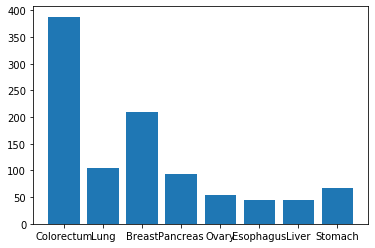

In [50]:
from collections import Counter
from matplotlib import pyplot
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [51]:
num_pipeline = Pipeline([
('imputer', SimpleImputer(strategy="median")),
# ('std_scaler', StandardScaler()),
])

df_prepared = num_pipeline.fit_transform(x)
new_x = pd.DataFrame(df_prepared)
new_x.columns = x.columns

In [52]:
# main data
x_train, x_test, y_train, y_test = train_test_split(
    new_x,
    y,
    test_size=0.25,
    random_state=42)

y_label_uniqe=list(y.unique())

### naive_bayes - multiclass

In [53]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_train, y_train)
predictions_nb = nb.predict(x_test)

In [54]:
print('Testing accuracy on selected features: %.3f' % acc(y_test, predictions_nb))

Testing accuracy on selected features: 0.302


### Random Forest - multiclass

In [55]:

clf_random = RandomForestClassifier(n_estimators=100, n_jobs=-1)

clf_random.fit(x_train, y_train)

# y_train_pred = clf.predict(x_train[x_train.columns[feat_cols]])
# print('Training accuracy on selected features: %.3f' % acc(y_train, y_train_pred))

y_test_pred = clf_random.predict(x_test)
print('Testing accuracy on selected features: %.3f' % acc(y_test, y_test_pred))

Testing accuracy on selected features: 0.690


In [56]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, nb.predict_proba(x_test), multi_class='ovr')

0.6233274496401889

In [57]:
from sklearn.metrics import confusion_matrix

cf_mat=confusion_matrix(y_test, predictions_nb)

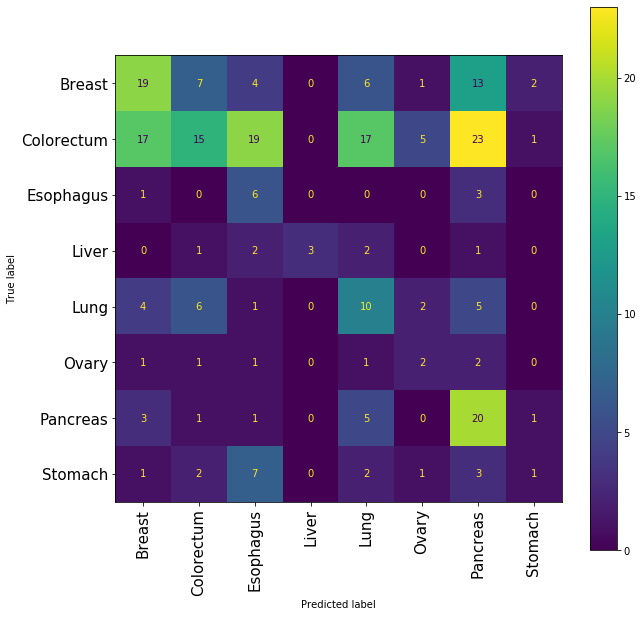

In [58]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='both', which='major', labelsize=15)
plot_confusion_matrix(nb, x_test, y_test,ax=ax)  
plt.xticks(rotation=90)
plt.show() 

In [59]:

def sensitivity_specificity_multiclass(conf_matrix, labels):

    labels = sorted(labels) #sort labels in case the input list was not sorted

    sensitivity = dict()

    specificity = dict()

    for i in range(0, conf_matrix.shape[0]):

        tp = conf_matrix[i,i]

        fn = np.sum(conf_matrix[i,:]) - conf_matrix[i,i]

        sensitivity[labels[i]] = tp / (tp + fn)

        tn = np.sum(np.delete(np.delete(conf_matrix, i, 1), i, 0))

        fp = np.sum(conf_matrix[:,i]) - conf_matrix[i,i]

        specificity[labels[i]] = tn / (tn + fp)

    return (sensitivity, specificity)

sensitivity, specificity=sensitivity_specificity_multiclass(cf_mat,y_label_uniqe)

In [60]:
sensitivity

{'Breast': 0.36538461538461536,
 'Colorectum': 0.15463917525773196,
 'Esophagus': 0.6,
 'Liver': 0.3333333333333333,
 'Lung': 0.35714285714285715,
 'Ovary': 0.25,
 'Pancreas': 0.6451612903225806,
 'Stomach': 0.058823529411764705}

In [61]:
specificity

{'Breast': 0.865,
 'Colorectum': 0.8838709677419355,
 'Esophagus': 0.8553719008264463,
 'Liver': 1.0,
 'Lung': 0.8526785714285714,
 'Ovary': 0.9631147540983607,
 'Pancreas': 0.7737556561085973,
 'Stomach': 0.9829787234042553}

#### Over sampling the data to evenly distribute the classes

In [62]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_over_resampled, y_over_resampled = ros.fit_resample(new_x, y)

In [63]:
x_o = pd.DataFrame(X_over_resampled)
x_o.columns = new_x.columns

Class=Colorectum, n=388 (38.607%)
Class=Lung, n=388 (38.607%)
Class=Breast, n=388 (38.607%)
Class=Pancreas, n=388 (38.607%)
Class=Ovary, n=388 (38.607%)
Class=Esophagus, n=388 (38.607%)
Class=Liver, n=388 (38.607%)
Class=Stomach, n=388 (38.607%)


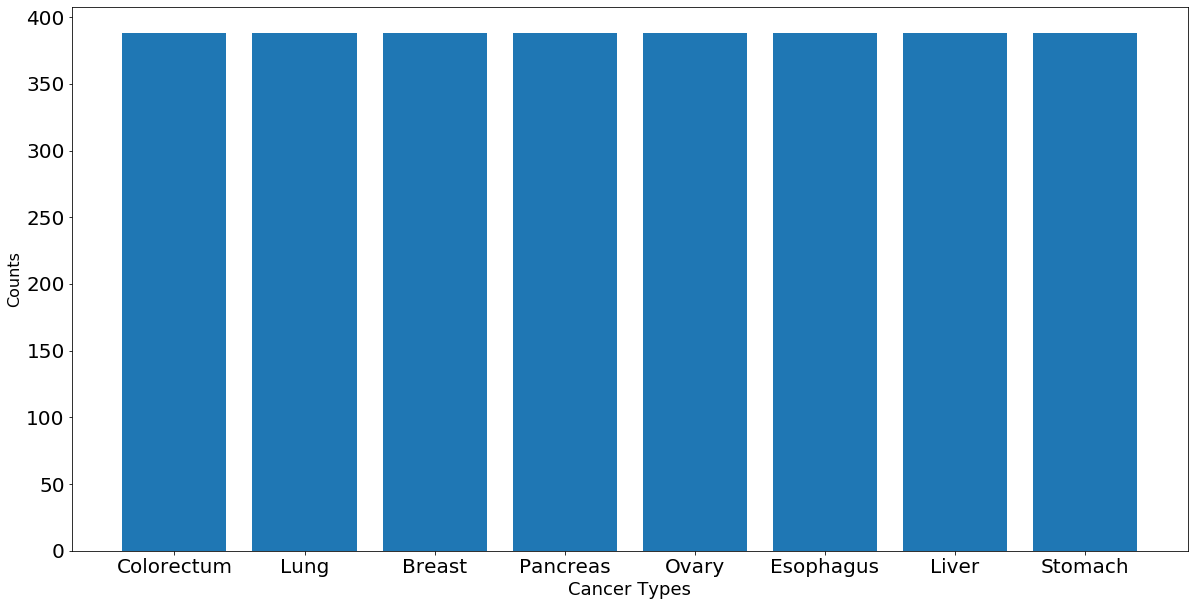

In [64]:
from collections import Counter
from matplotlib import pyplot
counter = Counter(y_over_resampled)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%s, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.figure(figsize=(20,10))
plt.xlabel('Cancer Types', fontsize=18)
plt.ylabel('Counts', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
pyplot.bar(counter.keys(), counter.values())

pyplot.show()

In [65]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(
    x_o,
    y_over_resampled,
    test_size=0.25,
    random_state=42)

#### naive_bayes - multiclass with Over Sampled Data

In [66]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(x_train_o, y_train_o)
predictions_nb = nb.predict(x_test_o)
print('Testing accuracy on selected features: %.3f' % acc(y_test_o, predictions_nb))

Testing accuracy on selected features: 0.393


In [67]:
## roc score for NB
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_o, nb.predict_proba(x_test_o), multi_class='ovr')

0.6555266441184011

In [68]:
from sklearn.metrics import confusion_matrix

cf_mat_o=confusion_matrix(y_test_o, predictions_nb)

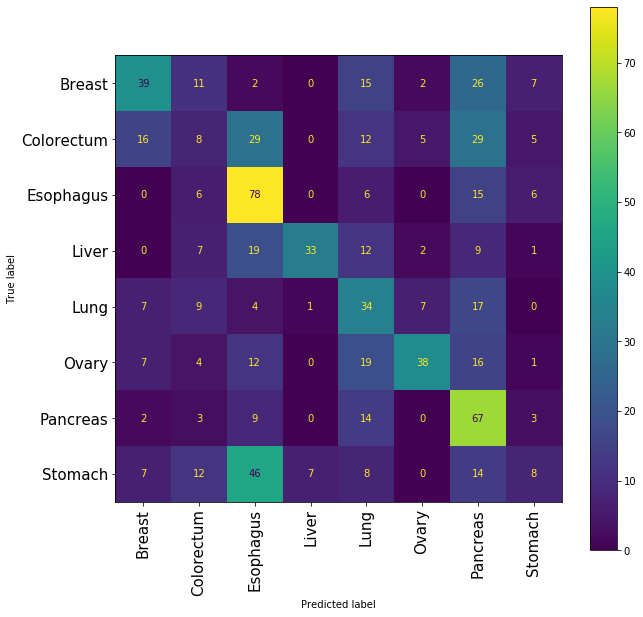

In [69]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='both', which='major', labelsize=15)
plot_confusion_matrix(nb, x_test_o, y_test_o,ax=ax)  
plt.xticks(rotation=90)
plt.show() 

#### Random forest - multiclass with over sampled data

In [70]:
clf_random_o = RandomForestClassifier(n_estimators=100, n_jobs=-1)

clf_random_o.fit(x_train_o, y_train_o)


y_test_pred_o = clf_random_o.predict(x_test_o)
print('Testing accuracy on selected features: %.3f' % acc(y_test_o, y_test_pred_o))

Testing accuracy on selected features: 0.965


In [71]:
## roc score for RandomForestClassifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_o, clf_random_o.predict_proba(x_test_o), multi_class='ovr')

0.9986781875208501

In [72]:
from sklearn.metrics import confusion_matrix

cf_mat_o=confusion_matrix(y_test_o, y_test_pred_o)

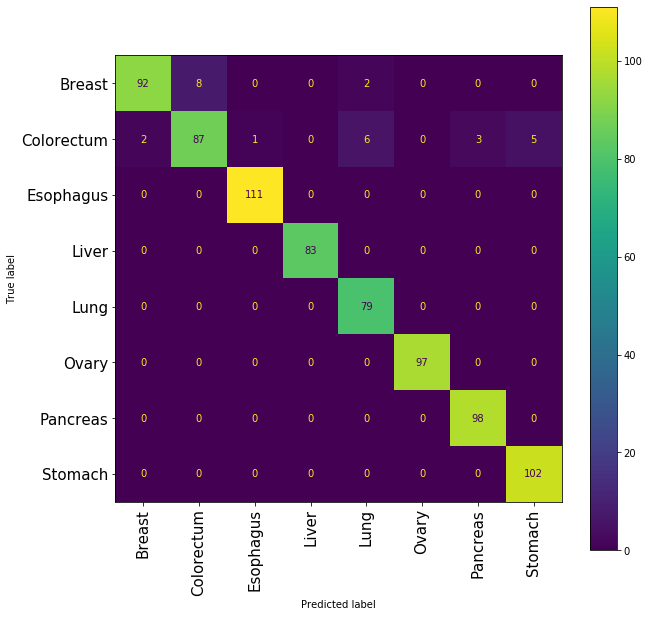

In [73]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='both', which='major', labelsize=15)
plot_confusion_matrix(clf_random_o, x_test_o, y_test_o,ax=ax)  
plt.xticks(rotation=90)
plt.show() 

In [74]:
sensitivity_o, specificity_o=sensitivity_specificity_multiclass(cf_mat_o,y_label_uniqe)

In [75]:
sensitivity_o

{'Breast': 0.9019607843137255,
 'Colorectum': 0.8365384615384616,
 'Esophagus': 1.0,
 'Liver': 1.0,
 'Lung': 1.0,
 'Ovary': 1.0,
 'Pancreas': 1.0,
 'Stomach': 1.0}

In [76]:
specificity_o

{'Breast': 0.9970326409495549,
 'Colorectum': 0.9880952380952381,
 'Esophagus': 0.9984962406015038,
 'Liver': 1.0,
 'Lung': 0.9885222381635581,
 'Ovary': 1.0,
 'Pancreas': 0.995575221238938,
 'Stomach': 0.9925816023738873}

### Hyper parameter tuning to improve random forest multiclass results

In [77]:
clf_random_grid = RandomForestClassifier() 

In [78]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20,30,40],
    
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
clf = GridSearchCV(clf_random_grid, param_grid)
clf.fit(x_train_o, y_train_o)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 30, 40],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]})

In [79]:
clf.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [80]:
clf_best_par = RandomForestClassifier(bootstrap=True,max_depth=18,min_samples_leaf=1,min_samples_split=4,n_estimators=250)



In [81]:
clf_best_par.fit(x_train_o, y_train_o)

y_test_pred = clf_best_par.predict(x_test_o)
print('Testing accuracy on selected features: %.3f' % acc(y_test_o, y_test_pred))

Testing accuracy on selected features: 0.956


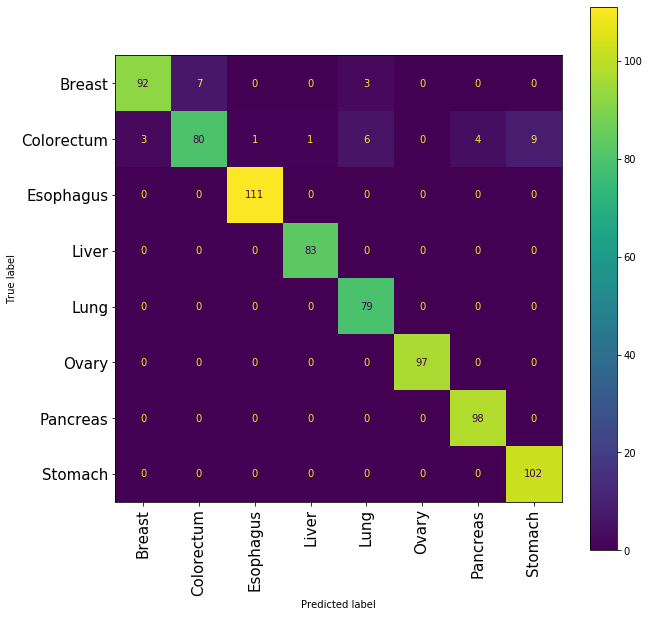

In [82]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt  
fig, ax = plt.subplots(figsize=(10, 10))
ax.tick_params(axis='both', which='major', labelsize=15)
plot_confusion_matrix(clf_best_par, x_test_o, y_test_o,ax=ax)  
plt.xticks(rotation=90)
plt.show() 

In [83]:
from sklearn.metrics import confusion_matrix

cf_mat=confusion_matrix(y_test_o, y_test_pred)

In [84]:
y_label_uniqe=list(y.unique())

In [85]:

def sensitivity_specificity_multiclass(conf_matrix, labels):

    labels = sorted(labels) #sort labels in case the input list was not sorted

    sensitivity = dict()

    specificity = dict()

    for i in range(0, conf_matrix.shape[0]):

        tp = conf_matrix[i,i]

        fn = np.sum(conf_matrix[i,:]) - conf_matrix[i,i]

        sensitivity[labels[i]] = tp / (tp + fn)

        tn = np.sum(np.delete(np.delete(conf_matrix, i, 1), i, 0))

        fp = np.sum(conf_matrix[:,i]) - conf_matrix[i,i]

        specificity[labels[i]] = tn / (tn + fp)

    return (sensitivity, specificity)

sensitivity, specificity=sensitivity_specificity_multiclass(cf_mat,y_label_uniqe)

In [86]:
sensitivity

{'Breast': 0.9019607843137255,
 'Colorectum': 0.7692307692307693,
 'Esophagus': 1.0,
 'Liver': 1.0,
 'Lung': 1.0,
 'Ovary': 1.0,
 'Pancreas': 1.0,
 'Stomach': 1.0}

In [87]:
specificity

{'Breast': 0.9955489614243324,
 'Colorectum': 0.9895833333333334,
 'Esophagus': 0.9984962406015038,
 'Liver': 0.9985569985569985,
 'Lung': 0.9870875179340028,
 'Ovary': 1.0,
 'Pancreas': 0.9941002949852508,
 'Stomach': 0.9866468842729971}